In [1]:
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np 
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import seaborn as sns
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [4]:
## Regularizing Curves
!pip install opencv-python

In [5]:
!pip install xgboost

In [23]:
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def rgb2bin(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    t, img_bin = cv2.threshold(
        img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV
    )
    return img_bin

def find_best_contour(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, h = cv2.findContours(
        img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    best_contour = max(contours, key=cv2.contourArea)
    return best_contour

def draw_contours(img, contours, index=-1, color=(255, 0, 0), thickness=2):
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)
def chain_hist(img_rgb):

    best_contour = find_best_contour(img_rgb)
    
    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7
    }

    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        hist[code] += 1

    return hist/hist.sum()
def create_df(data_path):
    
    # the class_dict is a mapping between class name and value
    class_dict = {
        'circle': 0,
        'square': 1,
        'star': 2,
        'triangle': 3
    }
    
    # we store image paths and outputs here
    df = []
    
    # for each class
    for class_name, class_value in class_dict.items():
        class_folder = os.path.join(data_path, class_name)
        # for each image in class folder
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            # if this is a "png" file, add its path and output
            if f_path.lower().endswith('.png'):
                df.append([f_path, class_value])
    
    # create a dataframe of image paths and outputs
    df = pd.DataFrame(df, columns=['path', 'output'])
    return df
def calculate_geometric_features(contour):
    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    
    # Calculate the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    aspect_ratio = float(w) / h
    
    # Extent is the ratio of contour area to bounding rectangle area
    rect_area = w * h
    extent = float(area) / rect_area
    
    # Solidity is the ratio of contour area to its convex hull area
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area
    
    # Circularity relates the area of the contour to its perimeter: 4π*Area / Perimeter^2
    # For a perfect circle, this value should be close to 1
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0
    
    # Number of corners (using Harris Corner Detection or approxPolyDP)
    epsilon = 0.01 * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)
    num_corners = len(approx)
    
    return np.array([area, perimeter, aspect_ratio, extent, solidity, circularity, num_corners])
def extract_features(img_paths):
    n = len(img_paths)
    number_of_geometric_features = 7  # From calculate_geometric_features
    X = np.zeros((n, 8 + number_of_geometric_features))
    
    for i in tqdm(range(n)):
        f_path = img_paths[i]
        img = imread(f_path)
        features = chain_hist(img)
        best_contour = find_best_contour(img)
        geometric_features = calculate_geometric_features(best_contour)
        X[i] = np.concatenate([features, geometric_features])
    return X
 
def predict(model, img):
    names = ['circle', 'square', 'star', 'triangle']
    # Extract both chain histogram and geometric features
    best_contour = find_best_contour(img)
    chain_features = chain_hist(img)
    geometric_features = calculate_geometric_features(best_contour)
    combined_features = np.concatenate([chain_features, geometric_features]).reshape(1, -1)
    # Use the combined features for prediction
    prediction = model.predict(combined_features)[0]
    return names[prediction]

def detect_connected_components(model, img, width_range, height_range):
    binary_img = rgb2bin(img)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=4)
    centroids = centroids.astype(int)
    img_copy = img.copy()
    for i in range(1, nLabels):
        x, y, w, h, _ = stats[i]
        (cx, cy) = centroids[i]
        acceptWidth = width_range[0] < w < width_range[1]
        acceptHeight = height_range[0] < h < height_range[1]
        if acceptWidth and acceptHeight:
            shape = img[y:y+h, x:x+w]
            label = predict(model, shape)  # Use the full_feature_predict function here
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(img_copy, label, (x, y-4), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (255, 0, 0))
    imshow(img_copy, figsize=(10, 10))

In [25]:
dataset_path = 'E:/shapes'
df = create_df(dataset_path)
df.head(5)

,path,output
0,E:/shapes\circle\0.png,0
1,E:/shapes\circle\1.png,0
2,E:/shapes\circle\10.png,0
3,E:/shapes\circle\100.png,0
4,E:/shapes\circle\1000.png,0


In [26]:
x= extract_features(df['path'])

y=df['output']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

100%|████████████████████████████████████████████████████████████████████████████| 14970/14970 [02:57<00:00, 84.51it/s]


In [8]:
# x.shape,y.shape

In [34]:
# Define and train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
}

# Lists to store train and test accuracies
train_accuracies = []
test_accuracies = []

# Train and evaluate each model for both training and testing datasets
for name, model in models.items():
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions on both the training and test sets
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    
    # Calculate the accuracy for both the training and test sets
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Append the accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print the accuracies
    print(f"{name} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

Logistic Regression - Train Accuracy: 0.9985, Test Accuracy: 0.9983
Decision Tree - Train Accuracy: 1.0000, Test Accuracy: 1.0000
Random Forest - Train Accuracy: 1.0000, Test Accuracy: 1.0000
SVM - Train Accuracy: 0.8430, Test Accuracy: 0.8450
XGBoost - Train Accuracy: 1.0000, Test Accuracy: 1.0000


In [35]:
# # Create a dataframe with the algorithm names and their scores
# algorithms = list(models.keys())
# scores = test_accuracies
# df = pd.DataFrame({'Algorithm': algorithms, 'Accuracy Score': scores})

# # Set the figure size and labels for the barplot
# sns.set_style(rc={'figure.figsize': (12, 8)})
# plt.xlabel("Algorithms")
# plt.ylabel("Accuracy Score")

# # Create the barplot
# sns.barplot(x='Algorithm', y='Accuracy Score', data=df, palette='viridis')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

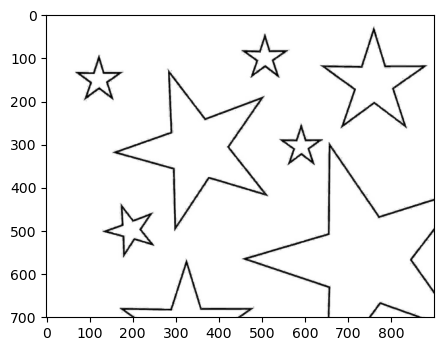

In [40]:
test_img = imread("C:/Users/Venkatesh/Downloads/img2.png")
imshow(test_img)

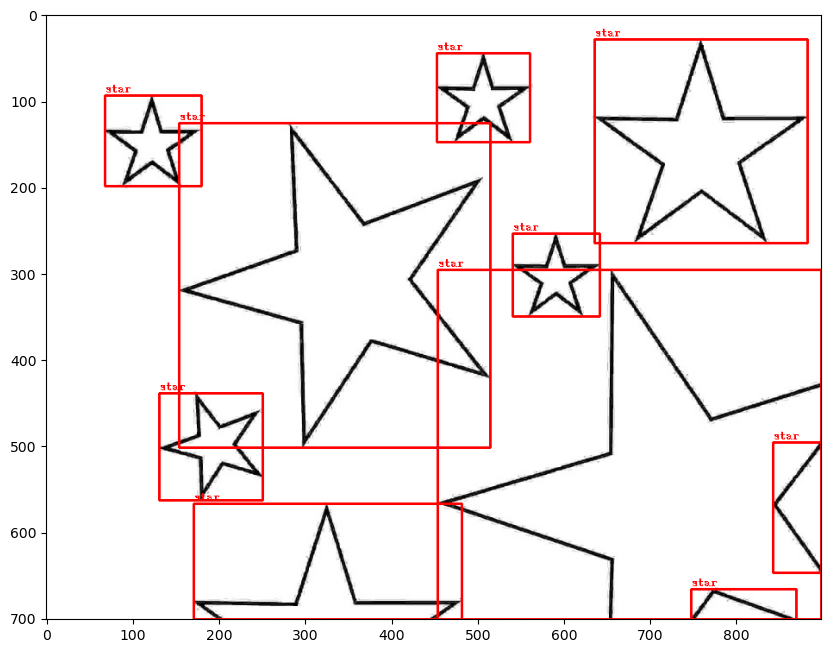

In [41]:
detect_connected_components(model,test_img, width_range=(1, 600), height_range=(1, 600))